# Tabular PlayGround Series
---

## Setup & Imports

In [52]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

from src import *
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from feature_engine.encoding import (
    OrdinalEncoder, 
    OneHotEncoder, 
    CountFrequencyEncoder, 
    RareLabelEncoder
)

import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

## Data

In [59]:
#load and look at the data
train = pd.read_csv('./datasets/tabular_playground_jan_2022/train.csv')
test = pd.read_csv('./datasets/tabular_playground_jan_2022/test.csv')

train = train.drop(columns="row_id")
test = test.drop(columns="row_id")

train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

print(train.shape)

train.head()

(26298, 5)


,date,country,store,product,num_sold
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


## EDA

In [60]:
# Convert date to datetime
train.date=pd.to_datetime(train.date)
test.date=pd.to_datetime(test.date)

# drop 29th Feb
train.drop(train[(train.date.dt.month==2) & (train.date.dt.day==29)].index, axis=0, inplace=True)

Text(0.5, 1.0, 'num_sold by store')

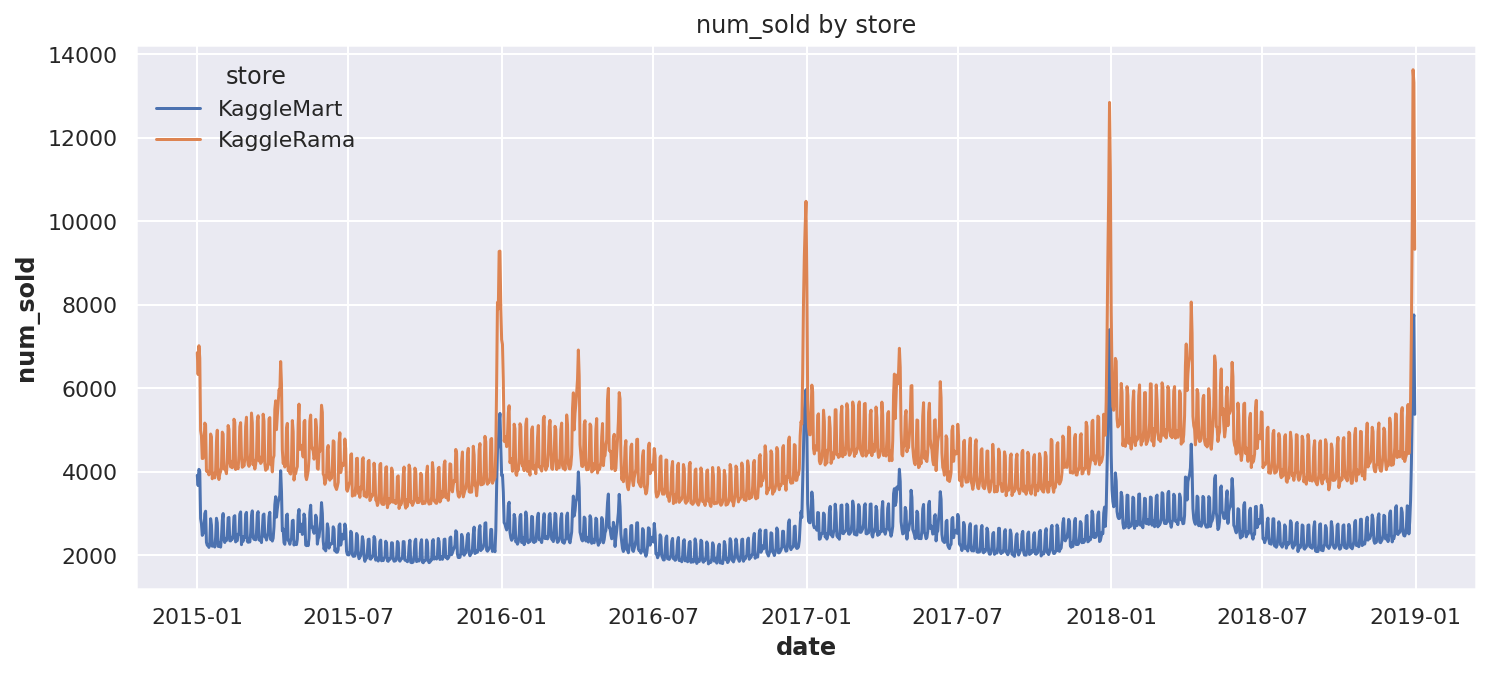

In [61]:
# Figure
plt.figure(figsize=(12,5))

# Groupby
aa=train.groupby(['date','store']).agg(num_sold=('num_sold','sum'))

# Lineplot
sns.lineplot(data=aa, x='date', y='num_sold', hue='store')

# Aesthetics
plt.title('num_sold by store')

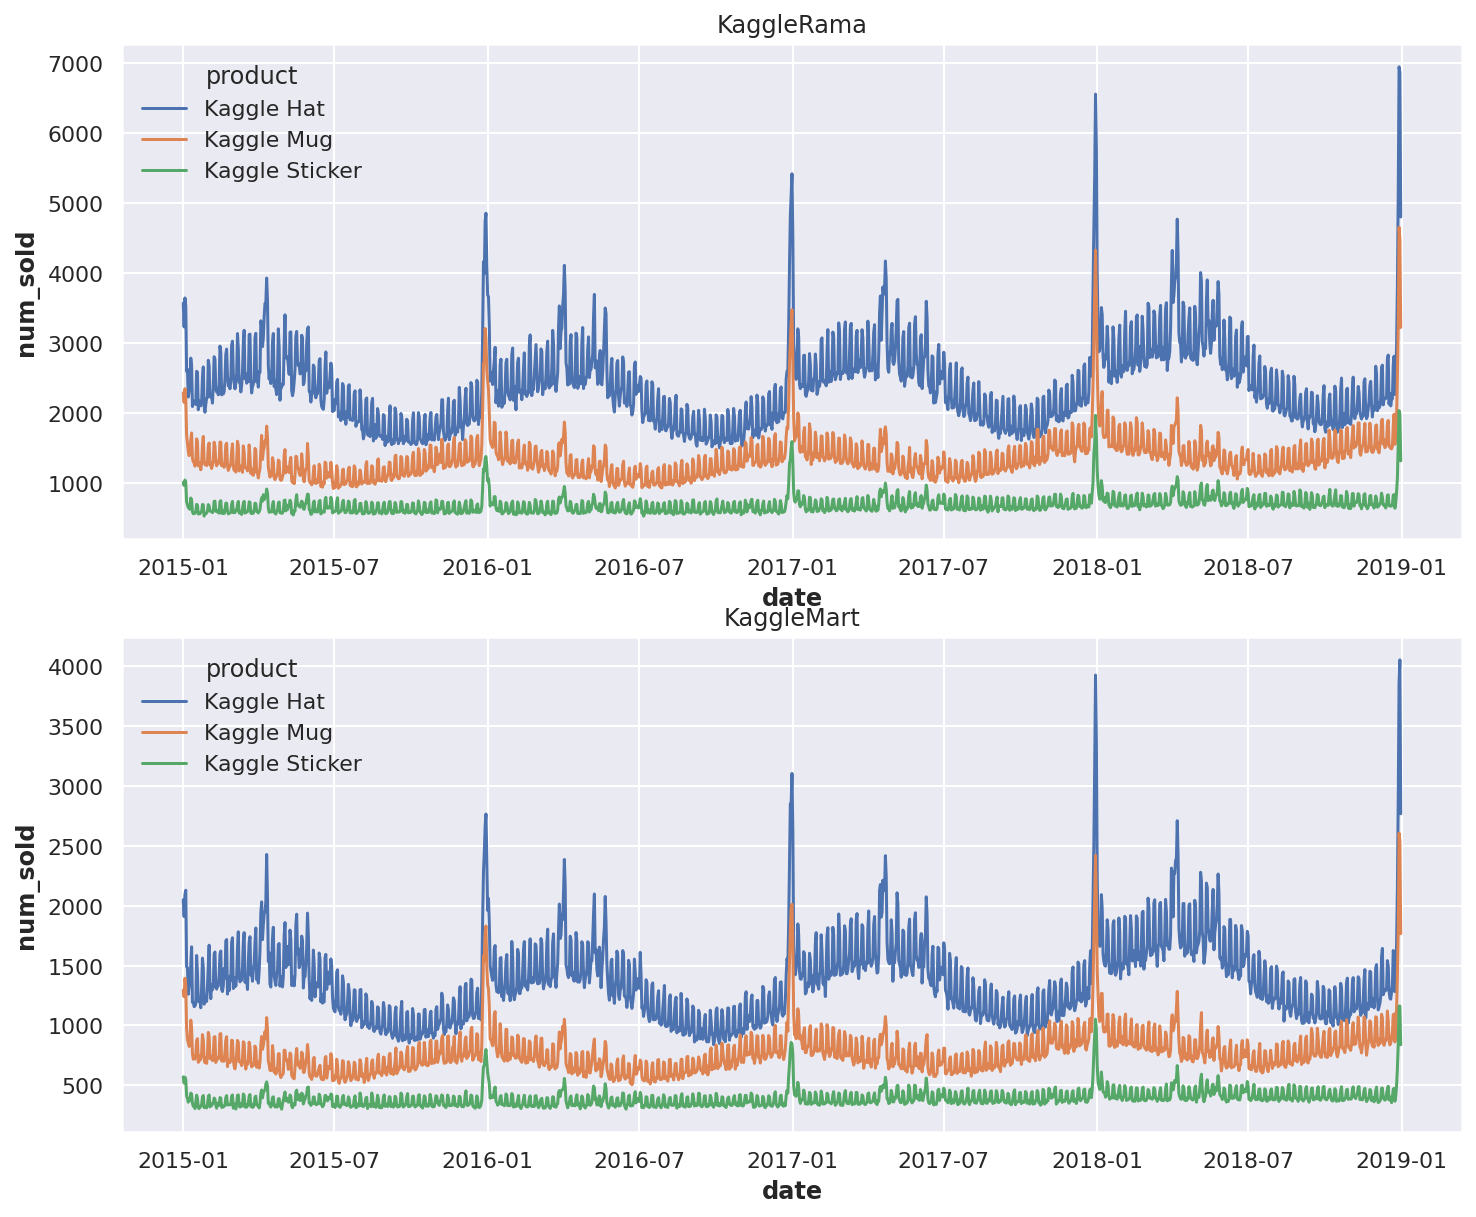

In [62]:
# Subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Groupby
KR=train[train.store=='KaggleRama']
KM=train[train.store=='KaggleMart']
bb=KR.groupby(['date','product']).agg(num_sold=('num_sold','sum'))
cc=KM.groupby(['date','product']).agg(num_sold=('num_sold','sum'))

# Lineplots
ax1=sns.lineplot(ax=axes[0], data=bb, x='date', y='num_sold', hue='product')
ax2=sns.lineplot(ax=axes[1], data=cc, x='date', y='num_sold', hue='product')

# Aesthetics
ax1.title.set_text('KaggleRama')
ax2.title.set_text('KaggleMart')

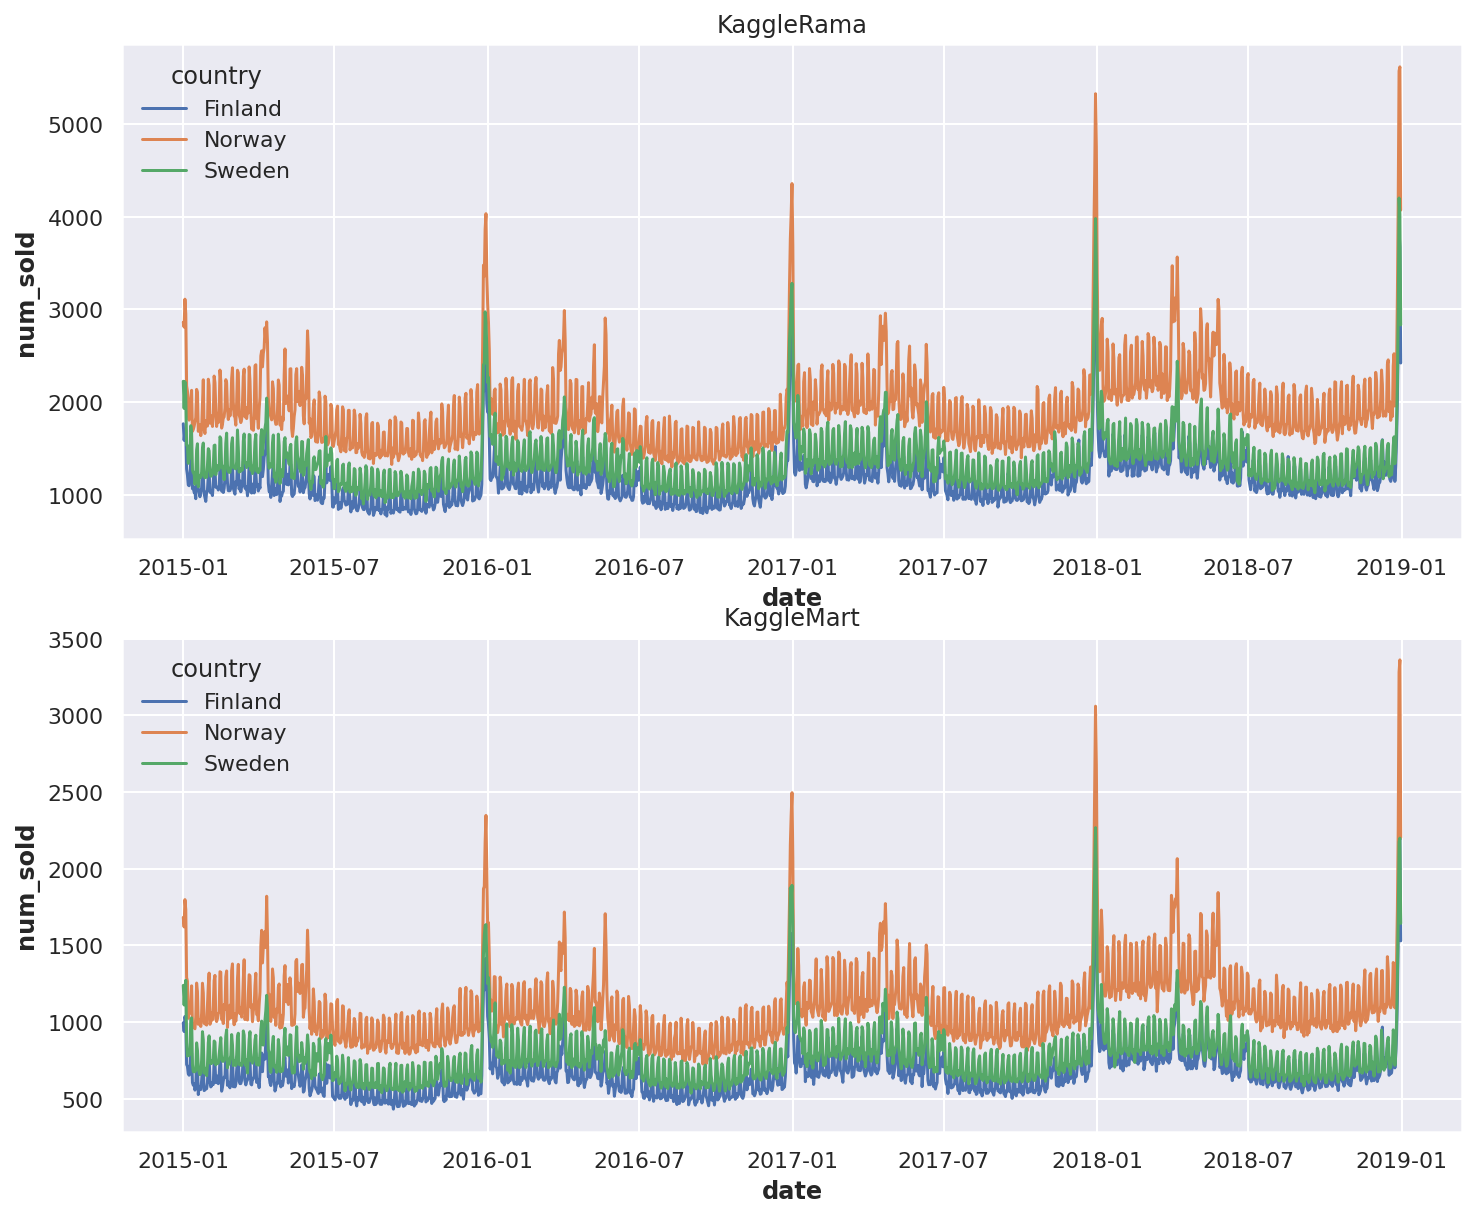

In [63]:
# Subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Groupby
dd=KR.groupby(['date','country']).agg(num_sold=('num_sold','sum'))
ee=KM.groupby(['date','country']).agg(num_sold=('num_sold','sum'))

# Lineplots
ax1=sns.lineplot(ax=axes[0], data=dd, x='date', y='num_sold', hue='country')
ax2=sns.lineplot(ax=axes[1], data=ee, x='date', y='num_sold', hue='country')

# Aesthetics
ax1.title.set_text('KaggleRama')
ax2.title.set_text('KaggleMart')

## Dataset split

In [66]:
train_finland = train[train["country"]=="Finland"].drop(columns="country")
train_norway = train[train["country"]=="Norway"].drop(columns="country")
train_sweden = train[train["country"]=="Sweden"].drop(columns="country")

test_finland = test[test["country"]=="Finland"].drop(columns="country")
test_norway = test[test["country"]=="Norway"].drop(columns="country")
test_sweden = test[test["country"]=="Sweden"].drop(columns="country")

ohe = OneHotEncoder(
    top_categories=10,
    drop_last=True,
    variables=["store", "product"]
)
    
train_finland = ohe.fit_transform(train_finland.set_index('date'))
train_norway = ohe.fit_transform(train_norway.set_index('date'))
train_sweden = ohe.fit_transform(train_sweden.set_index('date'))

test_finland = ohe.fit_transform(test_finland.set_index('date'))
test_norway = ohe.fit_transform(test_norway.set_index('date'))
test_sweden = ohe.fit_transform(test_sweden.set_index('date'))

train_finland = train_finland.resample("W").mean()
train_norway = train_norway.resample("W").mean()
train_sweden = train_sweden.resample("W").mean()

train_finland = train_finland.groupby("date").sum().reset_index()
train_norway = train_norway.groupby("date").sum().reset_index()
train_sweden = train_sweden.groupby("date").sum().reset_index()
test_finland = test_finland.groupby("date").sum().reset_index()
test_norway = test_norway.groupby("date").sum().reset_index()
test_sweden = test_sweden.groupby("date").sum().reset_index()
train_finland.head()

,date,num_sold,store_KaggleMart,store_KaggleRama,product_Kaggle Mug,product_Kaggle Hat,product_Kaggle Sticker
0,2015-01-04,446.250000,0.5,0.5,0.333333,0.333333,0.333333
1,2015-01-11,325.047619,0.5,0.5,0.333333,0.333333,0.333333
2,2015-01-18,285.785714,0.5,0.5,0.333333,0.333333,0.333333
3,2015-01-25,282.452381,0.5,0.5,0.333333,0.333333,0.333333
4,2015-02-01,280.714286,0.5,0.5,0.333333,0.333333,0.333333


In [67]:
from darts import TimeSeries


train_finland_ts = TimeSeries.from_dataframe(train_finland, 'date', 'num_sold', fill_missing_dates=True)
train_norway_ts = TimeSeries.from_dataframe(train_norway, 'date', 'num_sold', fill_missing_dates=True)
train_sweden_ts = TimeSeries.from_dataframe(train_sweden, 'date', 'num_sold', fill_missing_dates=True)

#test_finland_ts = TimeSeries.from_dataframe(test, 'date', 'num_sold', fill_missing_dates=True, freq=None)
#test_norway_ts = TimeSeries.from_dataframe(test_norway, 'date', 'num_sold', fill_missing_dates=True, freq=None)
#test_sweden_ts = TimeSeries.from_dataframe(test_sweden, 'date', 'num_sold', fill_missing_dates=True, freq=None)

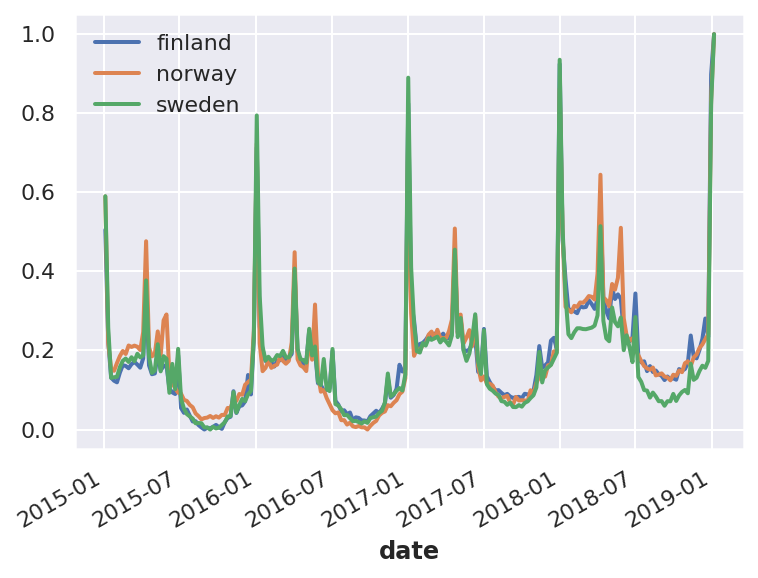

In [68]:
scaler_1, scaler_2, scaler_3 = Scaler(), Scaler(), Scaler()
train_finland_ts_scaled = scaler_1.fit_transform(train_finland_ts)
train_norway_ts_scaled = scaler_2.fit_transform(train_norway_ts)
train_sweden_ts_scaled = scaler_3.fit_transform(train_sweden_ts)

train_finland_ts_scaled.plot(label="finland")
train_norway_ts_scaled.plot(label="norway")
train_sweden_ts_scaled.plot(label="sweden")
plt.legend()

## Model training

In [73]:
model = NBEATSModel(
    input_chunk_length=28, output_chunk_length=1, n_epochs=100, random_state=0
)

model.fit(
    [train_finland_ts_scaled,train_norway_ts_scaled],
    verbose=True)

[2022-01-30 17:13:38,266] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 364 samples.
[2022-01-30 17:13:38,266] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 364 samples.
[2022-01-30 17:13:38,326] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-30 17:13:38,326] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

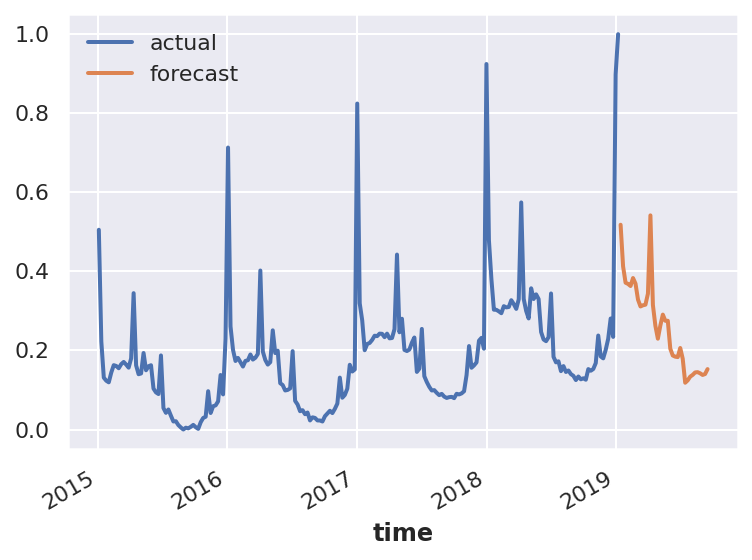

In [74]:
pred = model.predict(n=36, series=train_finland_ts_scaled)

train_finland_ts_scaled.plot(label="actual")
pred.plot(label="forecast")
#plt.legend()
#print("MAPE = {:.2f}%".format(mape(train_finland_ts, pred)))